# Step 1: Importing Necessary Libraries
We import the required libraries for data handling, preprocessing, and building the LSTM model.

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Step 2: Loading the Datasets
Load the training and testing datasets from CSV files into Pandas DataFrames.

In [5]:
# Load the datasets
train_data = pd.read_csv('Training_Data.csv')
test_data = pd.read_csv('Testing_Data.csv')

# Step 3: Select the Target Feature
Here, we use the 'precipitation' column as the target variable (y) for prediction.
Remove unnecessary columns like 'date' and set aside the target column.

In [6]:
target_feature = 'precipitation'

# For training data
train_data['target'] = train_data[target_feature].shift(-1)  # Shift to create one-step prediction
train_data.dropna(inplace=True)  # Drop the last row since it has NaN in 'target'
X_train = train_data.drop(columns=['target', 'date'])  # Input features
y_train = train_data['target']  # Target column

# For testing data
test_data['target'] = test_data[target_feature].shift(-1)
test_data.dropna(inplace=True)
X_test = test_data.drop(columns=['target', 'date'])
y_test = test_data['target']

# Step 4: Normalize the Data
Normalization scales all features between 0 and 1 to improve training performance.

In [7]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Normalize the target variable separately
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Step 5: Reshape the Data for LSTM
LSTM models require input data in 3D format: (samples, timesteps, features).

In [8]:
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


# Step 6: Define the LSTM Model
We define a sequential LSTM model with two LSTM layers and one Dense layer.

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)  # Single output for regression
])

# learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with Mean Squared Error as the loss function and Adam optimizer.
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Print the model summary for a detailed view of its architecture.
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 256)              │         307,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 128)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 566,177 (2.16 MB)

 Trainable params: 566,177 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

None


# Step 7: Train the Model
Train the LSTM model using the training dataset, and validate it with the testing dataset.

In [10]:

history = model.fit(X_train_reshaped, y_train_scaled,
                    epochs=300, batch_size=64,
                    validation_data=(X_test_reshaped, y_test_scaled))

Epoch 1/300
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 49s 22ms/step - loss: 7.1593e-05 - mae: 0.0021 - val_loss: 1.3533e-05 - val_mae: 5.8402e-04
Epoch 2/300
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 84s 23ms/step - loss: 7.4793e-05 - mae: 6.2191e-04 - val_loss: 1.3284e-05 - val_mae: 2.1850e-04
Epoch 3/300
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 3.0557e-05 - mae: 4.5162e-04 - val_loss: 1.3386e-05 - val_mae: 4.4911e-04
Epoch 4/300
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - loss: 4.3683e-05 - mae: 4.9836e-04 - val_loss: 1.3297e-05 - val_mae: 2.7087e-04
Epoch 5/300
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - loss: 2.4874e-05 - mae: 3.7864e-04 - val_loss: 1.3279e-05 - val_mae: 2.0152e-04
Epoch 6/300
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - loss: 4.2739e-05 - mae: 4.4325e-04 - val_loss: 1.3668e-05 - val_mae: 7.0304e-04
Epoch 7/300
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - loss: 3.5066e-05 - mae: 3.6597e-04 - val_loss: 1.3272e-05 - val_mae: 1.1233e-04
Epoch 8/300
1867/1867 ━━━━━━━━━

# Step 8: Evaluating the Model
The trained model is evaluated on the testing dataset to assess its generalization ability. Metrics such as loss and Mean Absolute Error are reported.

In [11]:
# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test_reshaped, y_test_scaled)
print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

934/934 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 6.7080e-06 - mae: 7.9295e-05
Test Loss: 1.3271209354570601e-05, Test Mean Absolute Error: 9.953867265721783e-05


# Step 9: Saving the Model
The trained model is saved as an .h5 file, allowing it to be reused later without retraining.

In [12]:
# Save the trained model
# model.save('lstm_environmental_model.h5')


# Step 10: Visualizing Training Progress
Plots of training and validation loss, as well as Mean Absolute Error, are generated to visualize how the model performed during training.

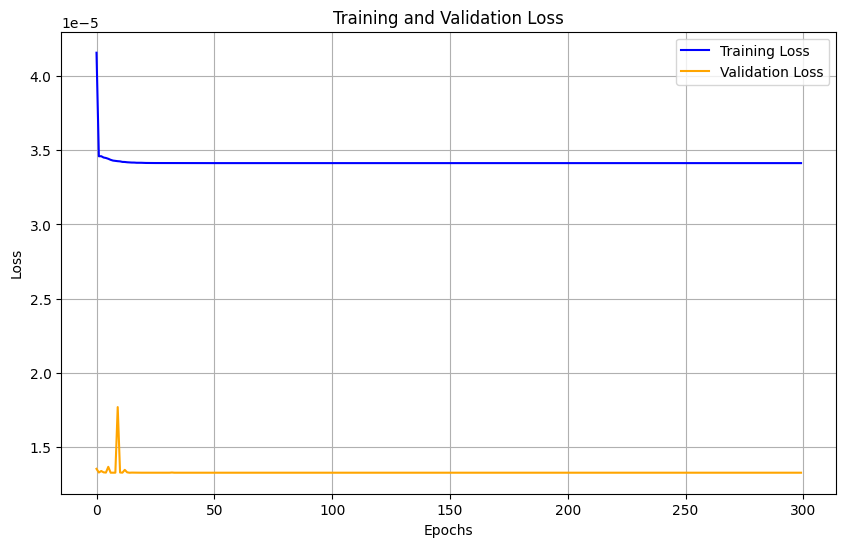

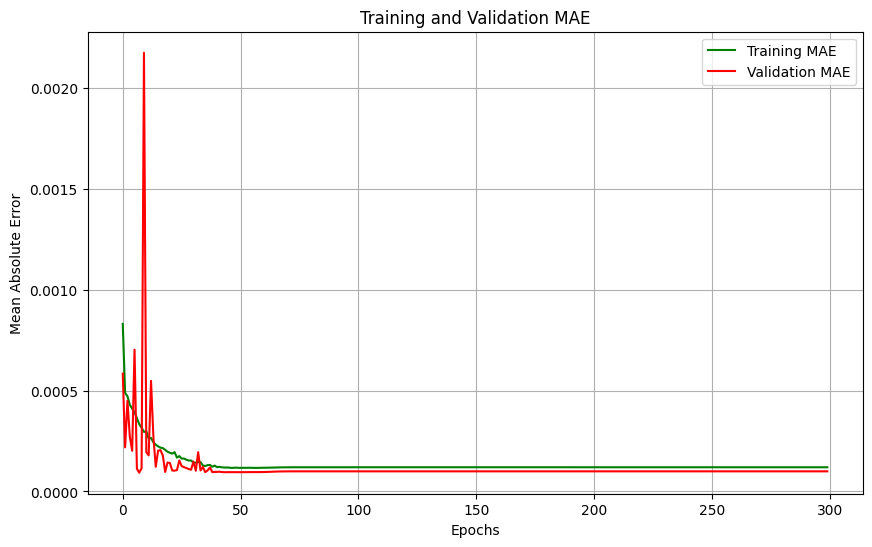

In [13]:
# Plot training and validation loss to analyze the learning process
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

# Plot training and validation Mean Absolute Error (MAE) to evaluate accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE', color='green')
plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')
plt.grid(True)
plt.show()

# Step 11: Visualize Actual vs Predicted Values

934/934 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


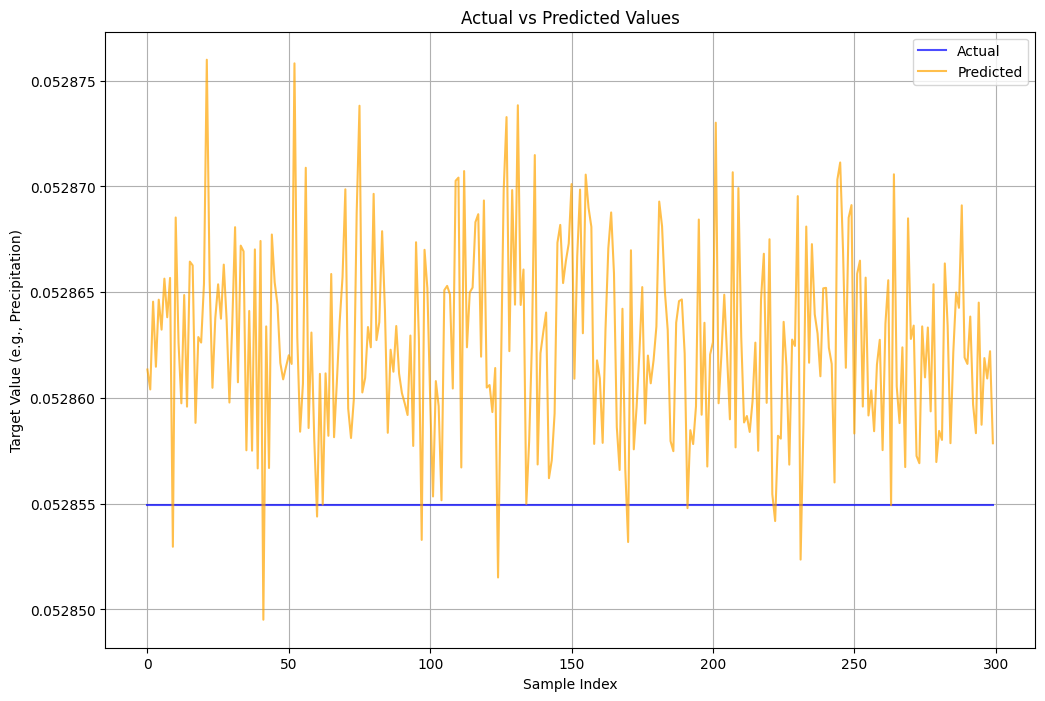

In [14]:
# Generate predictions
y_pred_scaled = model.predict(X_test_reshaped)  # Scaled predictions
y_pred = y_scaler.inverse_transform(y_pred_scaled)  # Convert predictions back to the original scale
y_actual = y_test.values  # Original target values

# Plot actual vs predicted values for a subset of the test data
plt.figure(figsize=(12, 8))
plt.plot(y_actual[:300], label='Actual', color='blue', alpha=0.7)
plt.plot(y_pred[:300], label='Predicted', color='orange', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Target Value (e.g., Precipitation)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

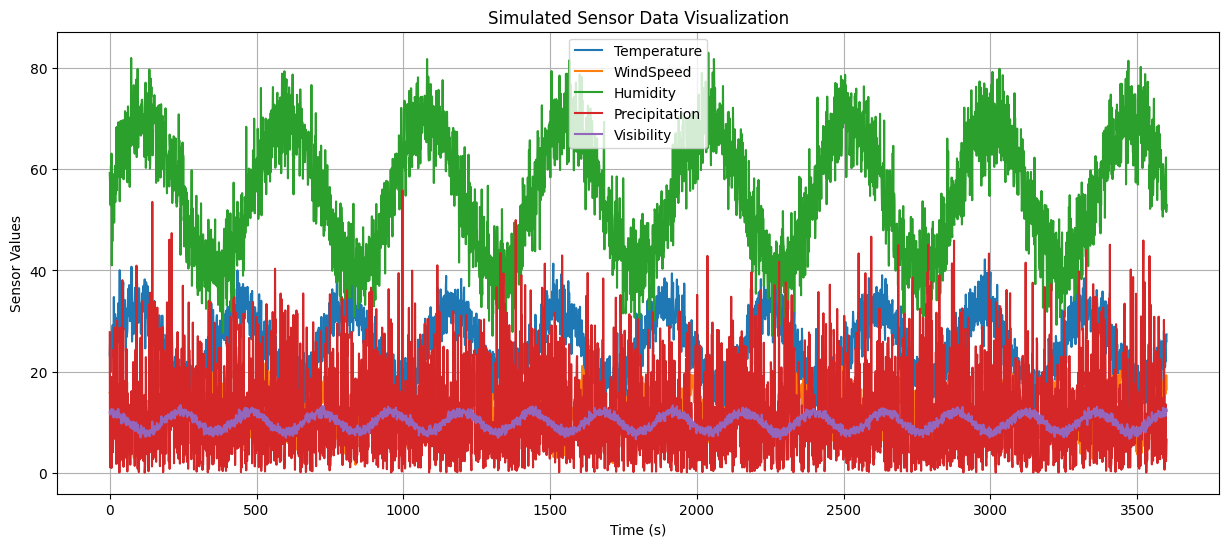

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data in Python
simulated_data = pd.read_csv('Enhanced_UAV_TrainingData.csv')

# Plot each column
plt.figure(figsize=(15, 6))
for column in simulated_data.columns[1:]:
    plt.plot(simulated_data['Time'], simulated_data[column], label=column)
plt.xlabel('Time (s)')
plt.ylabel('Sensor Values')
plt.legend()
plt.title('Simulated Sensor Data Visualization')
plt.grid(True)
plt.show()


In [4]:
print(simulated_data.isnull().sum())  # Check for null values
print(simulated_data.describe())     # Summary statistics


Time             0
Temperature      0
WindSpeed        0
Humidity         0
Precipitation    0
Visibility       0
dtype: int64
              Time  Temperature    WindSpeed     Humidity  Precipitation  \
count  3601.000000  3601.000000  3601.000000  3601.000000    3601.000000   
mean   1800.000000    25.050569    11.997309    55.726849      11.946219   
std    1039.663487     6.422642     4.008178    11.784512       9.094123   
min       0.000000     9.299431     1.576710    27.077557       0.009392   
25%     900.000000    19.675860     8.662620    45.413949       4.769435   
50%    1800.000000    24.942896    12.065840    56.564781       9.965295   
75%    2700.000000    30.419643    15.254040    65.614860      17.215210   
max    3600.000000    42.305824    22.252182    83.039390      55.833169   

        Visibility  
count  3601.000000  
mean     10.006931  
std       1.494266  
min       6.618082  
25%       8.705197  
50%       9.997278  
75%      11.333586  
max      13.403931  